# Galaxy Infall Simulation Toward the Great Attractor

---

## 🔍 Purpose

This notebook queries real galaxy data around the **Great Attractor** region, estimates their **infall motion** using a simplified gravitational model, and visualizes the resulting **3D vector field**. It is the core, exploratory notebook for the larger *Great Attractor Portfolio Project*.

---

## ⚙️ Workflow Summary

1. **Query Galaxy Data**
   - Retrieves galaxies within 10° of the Great Attractor (Norma Cluster region)
   - Uses the 2MASS Redshift Survey (2MRS) catalog via `astroquery`

2. **Compute Redshift & Distance**
   - Converts heliocentric velocity `cz` to redshift `z`
   - Computes distance using Hubble's Law:  
     \[
     d = \frac{cz}{H_0}
     \]

3. **Convert to 3D Cartesian Coordinates**
   - Transforms RA/Dec + distance into X, Y, Z (in Mpc)

4. **Simulate Infall Vectors**
   - Assumes each galaxy is moving toward a central point at the origin
   - Creates unit vectors scaled to ~300 km/s to represent gravitational infall

5. **Visualize the Vector Field**
   - Plots galaxies and their infall vectors in 3D space using `matplotlib`
   - Optionally saves cleaned data to CSV for reuse

---

## 🧰 Defined Functions

- `compute_redshift_distance(df)`  
- `convert_to_xyz(df)`  
- `simulate_infall_vectors(xyz)`  
- `plot_vector_field(xyz, velocity_vectors, skip=5)`  

Each function is modular and reusable across future scripts and notebooks.

---

## 📦 Dependencies

```bash
pip install astroquery astropy numpy pandas matplotlib scipy


# 📘 01_ga_workbench.ipynb

**This is Script 1 of N** in the _Great Attractor Project_ — a research portfolio on large-scale galactic dynamics using Python, astronomical datasets, and dynamical systems modeling.

This notebook serves as the **core exploratory script**: querying galaxies near the Great Attractor, simulating their motion, and plotting a 3D vector field to illustrate gravitational infall.


In [2]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

 ### Query Galaxies near the Great Attractor

In [7]:
# Set max results
Vizier.ROW_LIMIT = 1000

# Request all available columns
Vizier.columns = ['*']

# Great Attractor approximate location
coord = SkyCoord(ra=244.0*u.deg, dec=-44.0*u.deg, frame='icrs')

# Query 2MRS catalog
result = Vizier.query_region(coord, radius=10*u.deg, catalog="J/ApJS/199/26")

df = result[0].to_pandas()

# See what columns we get now
print(df.columns.tolist())

['ID', 'A', 'RAJ2000', 'DEJ2000', 'Kcmag', 'Hcmag', 'Jcmag', 'Ktmag', 'Htmag', 'Jtmag', 'E(B-V)', 'Riso', 'Rext', 'b/a', 'flags', 'type', 'cz', 'CAT', '2MX', 'SimbadName', 'NED']


In [8]:
c = 299792  # speed of light in km/s

df = df.dropna(subset=["cz"])
df["z"] = df["cz"] / c

In [9]:
H0 = 70  # Hubble constant (km/s/Mpc)
df["distance_mpc"] = df["cz"] / H0

In [10]:
coords = SkyCoord(ra=df["RAJ2000"].values*u.deg,
                  dec=df["DEJ2000"].values*u.deg,
                  distance=df["distance_mpc"].values*u.Mpc)

x = coords.cartesian.x.value
y = coords.cartesian.y.value
z = coords.cartesian.z.value

xyz = np.stack([x, y, z], axis=1)

In [11]:
# Assuming you already have `xyz` as a (N, 3) array
center = np.array([0, 0, 0])  # Great Attractor center

# Compute direction from each galaxy to the center
direction_vectors = center - xyz

# Normalize and scale to simulate velocity vectors
norms = np.linalg.norm(direction_vectors, axis=1).reshape(-1, 1)
velocity_vectors = (direction_vectors / norms) * 300  # scale to 300 km/s typical infall

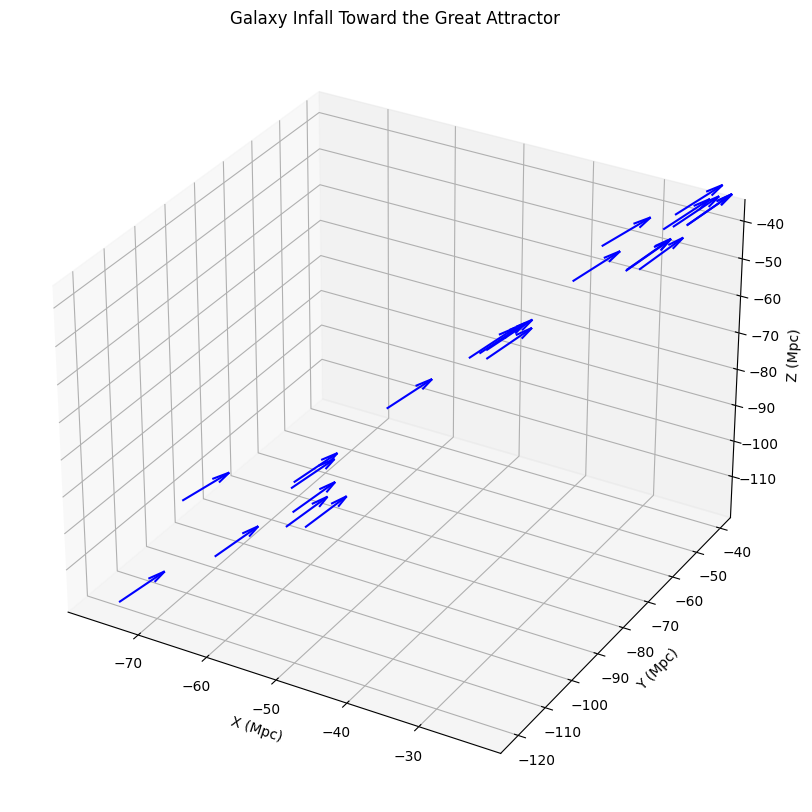

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Optional: Skip every 5th point for clarity
skip = 5
x_, y_, z_ = xyz[::skip,0], xyz[::skip,1], xyz[::skip,2]
u_, v_, w_ = velocity_vectors[::skip,0], velocity_vectors[::skip,1], velocity_vectors[::skip,2]

ax.quiver(x_, y_, z_, u_, v_, w_, length=10, normalize=True, color='blue')

ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')
ax.set_zlabel('Z (Mpc)')
ax.set_title("Galaxy Infall Toward the Great Attractor")
plt.show()

In [16]:
#1. Redshift + Distance Calculation from cz

def compute_redshift_distance(df, cz_col="cz", H0=70, c=299792):
    df = df.dropna(subset=[cz_col])
    df["z"] = df[cz_col] / c
    df["distance_mpc"] = df[cz_col] / H0
    return df

#2. Convert RA/Dec + Distance → Cartesian Coordinates

def convert_to_xyz(df, ra_col="RAJ2000", dec_col="DEJ2000", dist_col="distance_mpc"):
    coords = SkyCoord(ra=df[ra_col].values*u.deg,
                      dec=df[dec_col].values*u.deg,
                      distance=df[dist_col].values*u.Mpc)

    x = coords.cartesian.x.value
    y = coords.cartesian.y.value
    z = coords.cartesian.z.value

    return np.stack([x, y, z], axis=1)

#3. Simulate Infall Vectors Toward GA Center

def simulate_infall_vectors(xyz, center=(0, 0, 0), magnitude=300):
    center = np.array(center)
    direction_vectors = center - xyz
    norms = np.linalg.norm(direction_vectors, axis=1).reshape(-1, 1)
    velocity_vectors = (direction_vectors / norms) * magnitude
    return velocity_vectors

#4. Plot the Vector Field in 3D

def plot_vector_field(xyz, velocity_vectors, skip=5):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Downsample for clarity
    x_, y_, z_ = xyz[::skip, 0], xyz[::skip, 1], xyz[::skip, 2]
    u_, v_, w_ = velocity_vectors[::skip, 0], velocity_vectors[::skip, 1], velocity_vectors[::skip, 2]

    ax.quiver(x_, y_, z_, u_, v_, w_, length=10, normalize=True, color='blue', alpha=0.6)

    ax.set_xlabel('X (Mpc)', fontsize=12)
    ax.set_ylabel('Y (Mpc)', fontsize=12)
    ax.set_zlabel('Z (Mpc)', fontsize=12)
    ax.set_title("Simulated Infall of Galaxies Toward the Great Attractor", fontsize=14, pad=20)

    # Mark the Great Attractor at the origin
    ax.scatter(0, 0, 0, color='red', s=100, label='Great Attractor (assumed center)')
    ax.legend()

    plt.tight_layout()
    plt.show()



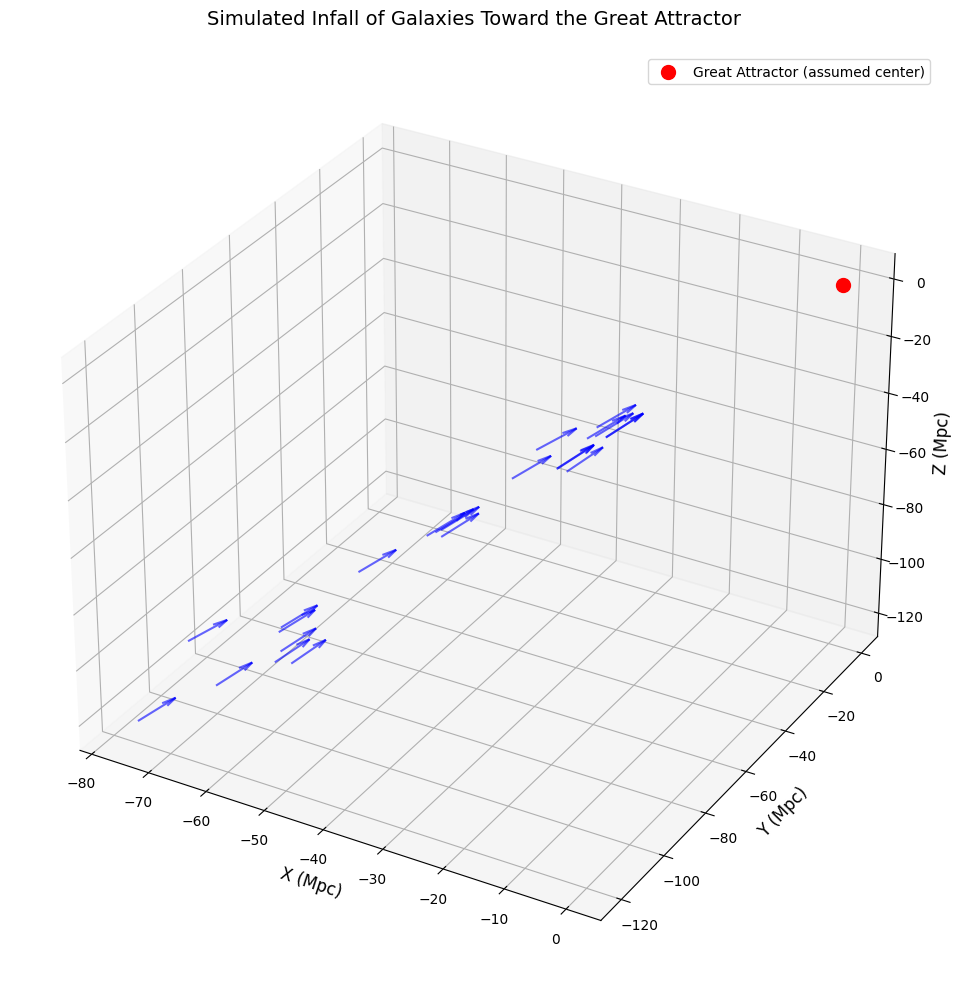

In [17]:
# Step 1: Compute z and distance
df = compute_redshift_distance(df)

# Step 2: Convert to Cartesian
xyz = convert_to_xyz(df)

# Step 3: Simulate infall vectors
velocity_vectors = simulate_infall_vectors(xyz)

# Step 4: Plot
plot_vector_field(xyz, velocity_vectors)


### TEST PIPELINE

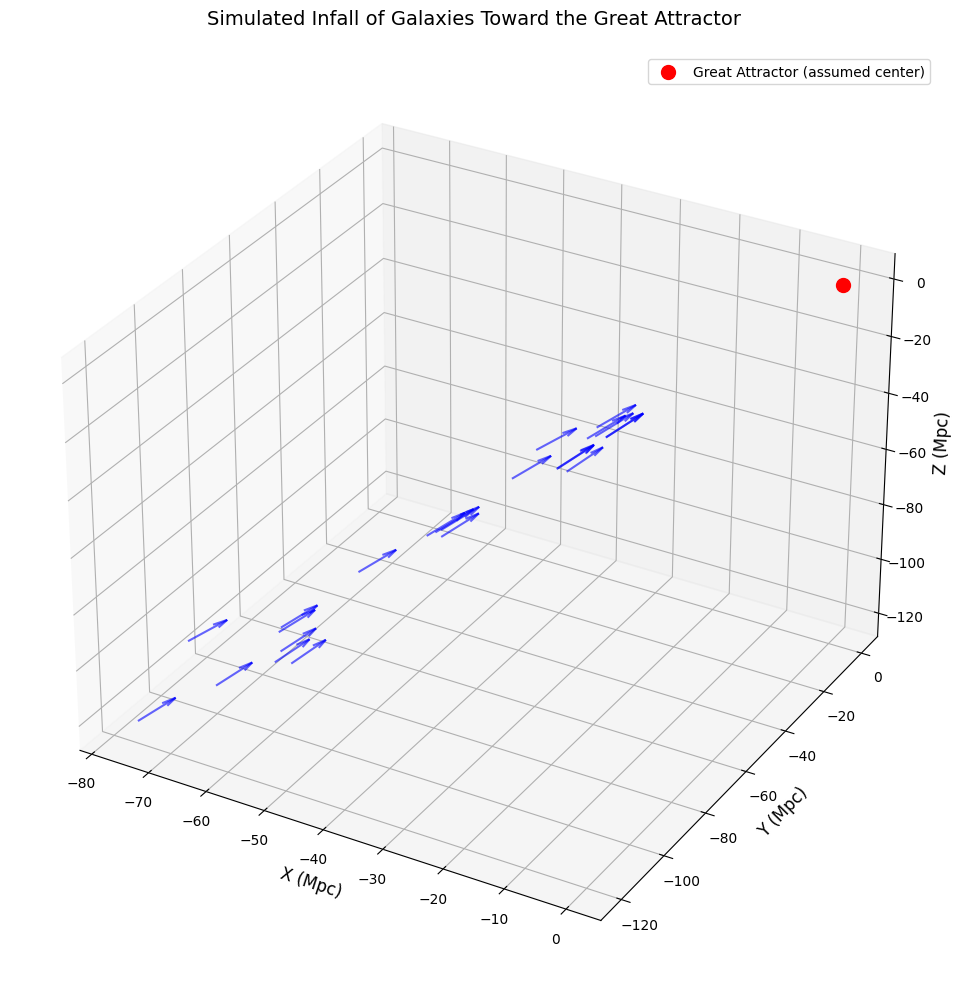

In [18]:
# Step 1: Clean + compute redshift and distance
df = compute_redshift_distance(df)

# Step 2: Convert to 3D
xyz = convert_to_xyz(df)

# Step 3: Simulate velocity vectors toward GA
velocity_vectors = simulate_infall_vectors(xyz)

# Step 4: Plot
plot_vector_field(xyz, velocity_vectors, skip=5)

In [15]:
df.to_csv("ga_galaxies.csv", index=False)